In [1]:
import numpy as np
from pathlib import Path
import scipy.io as sio
from scipy.interpolate import interp2d
import imageio
import cv2
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import time

from skimage import data, draw
from skimage.registration import phase_cross_correlation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle, vortex
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

from spyrit.misc.disp import *
from spyrit.misc.metrics import *
from spyrit.learning.dataset import *


In [2]:
data_root = "../../data/UCF-101";
dataset_path="../../data/UCF-101-frames";
split_path="../../data/ucfTrainTestlist";
batch_size=20;
img_size=64;
num_frames=21;
dt = 1/25;

np.random.seed(seed=0)

In [3]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.FloatTensor;
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
image_shape = (1, img_size, img_size)




# Define training set
train_dataset = Dataset_prediction(
    dataset_path = dataset_path,
    split_path = split_path,
    split_number = 1,
    input_shape = image_shape,
    sequence_length = num_frames,
    training = True,
)
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4)
# Define test set
test_dataset = Dataset_prediction(
    dataset_path = dataset_path,
    split_path = split_path,
    split_number = 1,
    input_shape = image_shape,
    sequence_length = num_frames,
    training=False,
)
testloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 4)
dataloaders = {'train':trainloader, 'val':testloader};

/home/lorente/.conda/envs/spyrit-env/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [4]:
# from scipy.interpolate import interpn
from scipy.interpolate import griddata, RectBivariateSpline
# def warp(I1, flow):
#     nx =  I1.shape[0];
#     ny =  I1.shape[1];
#     # t1 = time.time();
#     x = np.linspace(1, nx, nx);
#     y = np.linspace(1, ny, ny);
#     X, Y = np.meshgrid(x, y);
#     # t2 = time.time();
#     # print(t2-t1); # 10^-4
#     I2 = griddata((np.reshape(X,(nx*ny)),np.reshape(Y,(nx*ny))), np.reshape(I1,(nx*ny)), (X+flow[:,:,0],Y+flow[:,:,1]), method='cubic', fill_value = 0);
#     # t1 = time.time();
#     # print(t1-t2);# 10^-2
#     return I2;

# def warp_bis(I1, flow):
#     """Bonne fonction pour faire ce qui nous intéresse!"""
#     h, w = flow.shape[:2];
#     flow[:,:,0] += np.arange(w)
#     flow[:,:,1] += np.arange(h)[:,np.newaxis]
#     I2 = cv2.remap(I1, flow, None, cv2.INTER_LINEAR);
#     return I2;


def float2_bit(I):
    I_8_bit = 255*(I+1)/2
    I_8_bit = I_8_bit.astype('uint8')
    return I_8_bit

def float2_bit_gen(I):
    I_8_bit = 255*(I-np.amin(I))/(np.amax(I)-np.amin(I))
    I_8_bit = I_8_bit.astype('uint8')
    return I_8_bit

# Test on Real Videos

In [5]:
A = next(iter(testloader));

In [6]:
x = A[0][0,:,:,:,:];
I1 = torch2numpy(x[3,0,:,:]);
I2 = torch2numpy(x[4,0,:,:]);

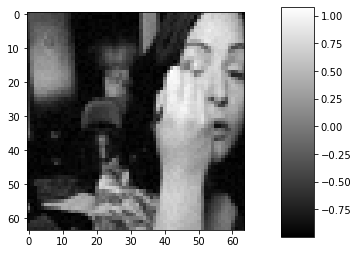

In [7]:
imagesc(I1)

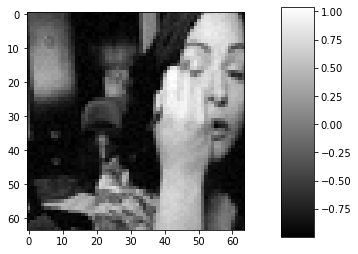

In [8]:
imagesc(I2)

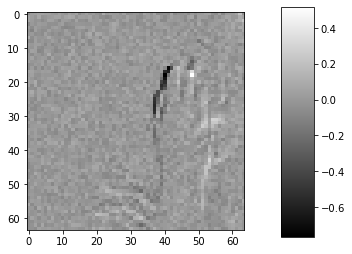

In [9]:
imagesc(I1-I2)

In [10]:
I1_8_bit = float2_bit(I1);
I2_8_bit = float2_bit(I2);

# Test on synthetic video

In [11]:
def boule_vid_parabola(n, r, n_frames, v):
    x = np.linspace(-1, 1, n);
    y = np.linspace(-1, 1, n);
    X, Y = np.meshgrid(x, y);
    Vid = np.zeros((n_frames,n,n))
    for i in range(n_frames):
        t = v*i/n_frames;
        x_c = t;
        y_c =  t*(t-1);
        msk = 1.0*((X-x_c)**2+(Y-y_c)**2<r);
        Vid[i,:,:] = msk;
    return Vid;

In [12]:
n_frames = 10;
A = boule_vid_parabola(64, 0.025, n_frames, 1)

In [13]:
dt = 1/n_frames

In [14]:
A.shape

(10, 64, 64)

In [15]:
# imagesc(A[0,:,:])
# imagesc(A[3,:,:])
# imagesc(A[6,:,:])
# imagesc(A[9,:,:])

In [16]:
I1 = A[0,:,:].astype(np.int32);
I2 = A[1,:,:].astype(np.int32);

In [17]:
I1_8_bit = float2_bit(I1);
I2_8_bit = float2_bit(I2);

In [18]:
t1 = time.time();
v, u = optical_flow_tvl1(I1, I2)
t2 = time.time();

In [19]:
t2-t1

0.030216693878173828

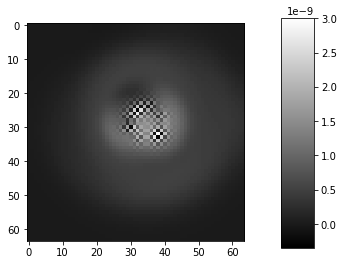

In [20]:
imagesc(u)

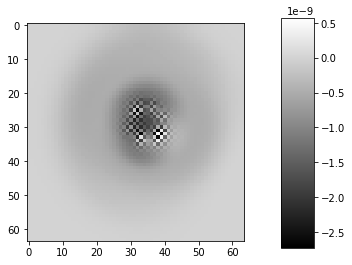

In [21]:
imagesc(v)

In [22]:
t1 = time.time();
v, u = optical_flow_ilk(I1, I2, radius=15)
t2 = time.time();

In [23]:
t2-t1

0.03099203109741211

In [24]:
# u = flow[:,:,0];
# v = flow[:,:,1];

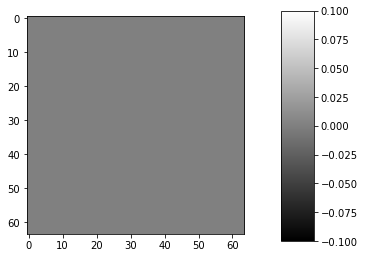

In [25]:
imagesc(u)

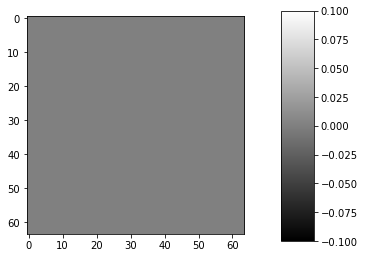

In [26]:
imagesc(v)

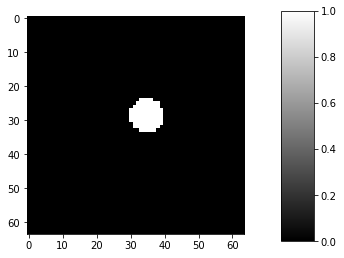

In [27]:
nr, nc = I1.shape
row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
image1_warp = warp(I2, np.array([row_coords - 100000000*v, col_coords - 100000000*u]),
                   mode='edge', preserve_range=True)
imagesc(image1_warp)

In [28]:
np.amax(image1_warp)

1.0

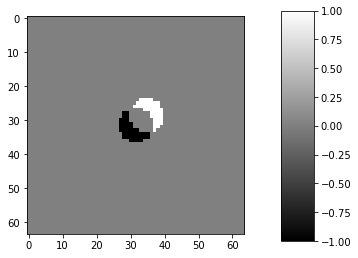

In [29]:
imagesc(image1_warp-I1)

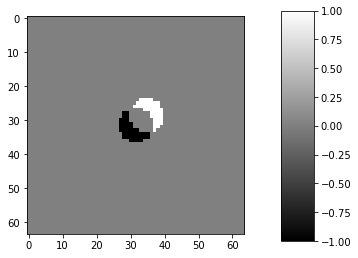

In [30]:
imagesc(I2-I1)

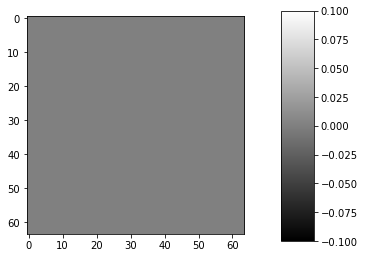

In [31]:
imagesc(np.abs(I2-I1)-np.abs(image1_warp-I1))

It seems to compute that `I3_check = warp_bis(I1,-dt*flow);` is the correct one